# Step 31) 많은 종목 자동 처리용: 다운로드/정리

- 중요: yfinance로 KOSPI 전체를 자동 수집하는 “티커 리스트 생성”은 소스가 필요합니다.
- 그래서 여기선 (A) 사용자가 준 tickers 리스트, 또는 (B) CSV로 tickers를 로드하는 방식으로 갑니다.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

def load_tickers_from_csv(path: str, col: str = "ticker") -> list[str]:
    df = pd.read_csv(path)
    tickers = df[col].dropna().astype(str).unique().tolist()
    return tickers

def download_prices(tickers: list[str], start="2022-01-01") -> pd.DataFrame:
    px = yf.download(
        tickers,
        start=start,
        auto_adjust=True,
        progress=False,
        group_by="column"
    )["Close"]
    px = px.dropna(how="all")
    return px

def filter_by_coverage(prices: pd.DataFrame, min_frac: float = 0.9) -> pd.DataFrame:
    """
    각 종목이 전체 기간 중 최소 min_frac 비율만큼 데이터가 있으면 유지
    """
    coverage = prices.notna().mean(axis=0)
    keep = coverage[coverage >= min_frac].index.tolist()
    return prices[keep]


사용 예:

In [4]:
# (A) 직접 티커 리스트 제공
tickers = ["005930.KS", "000660.KS", "105560.KS", "005380.KS", "402340.KS", "034020.KS", "035420.KS", "012450.KS", "055550.KS", "068270.KS", "000270.KS", "028260.KS", "086790.KS", "012330.KS", "035720.KS", "005490.KS", "267260.KS", "009540.KS", "373220.KS", "316140.KS", "207940.KS", "329180.KS", "006400.KS", "010140.KS", "042660.KS", "015760.KS", "000810.KS", "009150.KS", "051910.KS", "064350.KS", "032830.KS", "033780.KS", "030200.KS", "066570.KS", "034730.KS", "047810.KS", "267250.KS", "010120.KS", "138040.KS", "010130.KS", "298040.KS", "017670.KS", "096770.KS", "323410.KS", "003550.KS", "259960.KS", "352820.KS", "042700.KS", "071050.KS", "006800.KS", "000100.KS", "086280.KS", "018260.KS", "003670.KS", "011200.KS", "003490.KS", "079550.KS", "180640.KS", "024110.KS", "005830.KS", "000720.KS", "003230.KS", "000150.KS", "016360.KS", "021240.KS", "0126Z0.KS", "161390.KS", "272210.KS", "011070.KS", "032640.KS", "028050.KS", "090430.KS", "036570.KS", "010950.KS", "034220.KS", "326030.KS", "005940.KS", "241560.KS", "128940.KS", "009830.KS", "078930.KS", "443060.KS", "004020.KS", "011790.KS", "047050.KS", "051900.KS", "035250.KS", "271560.KS", "097950.KS", "454910.KS", "011780.KS", "251270.KS", "022100.KS", "029780.KS", "036460.KS", "450080.KS", "377300.KS", "011170.KS", "302440.KS", "004990.KS"]  # 여기에 많이 넣으세요

prices = download_prices(tickers, start="2022-01-01")
prices = filter_by_coverage(prices, min_frac=0.9)

tickers = prices.columns.tolist()
print("kept tickers:", len(tickers))


kept tickers: 96


# Step 32) 10일 rolling 피쳐 만들기 (로그수익률 포함) + 텐서 구축

In [5]:
def rolling_mdd_from_logrets(arr: np.ndarray) -> float:
    arr = arr[~np.isnan(arr)]
    if arr.size < 2:
        return np.nan
    cum = np.exp(arr).cumprod()
    peak = np.maximum.accumulate(cum)
    dd = cum / peak - 1.0
    return float(dd.min())

def rolling_slope(series: pd.Series, window: int) -> pd.Series:
    idx = np.arange(window)

    def slope_fn(v: np.ndarray) -> float:
        if np.any(np.isnan(v)):
            return np.nan
        x0 = idx - idx.mean()
        y0 = v - v.mean()
        denom = (x0**2).sum()
        return float((x0 * y0).sum() / denom) if denom != 0 else 0.0

    return series.rolling(window).apply(slope_fn, raw=True)

def make_feature_panel(prices: pd.DataFrame, window: int = 10, add_optional: bool = True) -> pd.DataFrame:
    """
    returns: index=(date, ticker), columns=features
    """
    lr = np.log(prices).diff()

    feats = {
        # 요청사항: 로그수익률 포함
        "log_ret": lr,
        "roll_mean": lr.rolling(window, min_periods=window).mean(),
        "roll_vol": lr.rolling(window, min_periods=window).std(),
        "roll_mdd": lr.rolling(window, min_periods=window).apply(rolling_mdd_from_logrets, raw=True),
    }

    if add_optional:
        feats["cum_logret"] = lr.rolling(window, min_periods=window).sum()
        logp = np.log(prices)
        feats["trend_slope"] = logp.apply(lambda s: rolling_slope(s, window))

    panel = pd.concat(feats, axis=1)      # columns: (feature, ticker)
    panel = panel.stack(level=1)          # index: (date, ticker)
    panel.index.names = ["date", "ticker"]
    return panel.dropna()

def slice_last_n_dates(feat_panel: pd.DataFrame, n: int) -> pd.DataFrame:
    dates = feat_panel.index.get_level_values("date").unique().sort_values()
    last_dates = dates[-n:]
    return feat_panel.loc[(last_dates, slice(None)), :]

def build_tensor(feat_panel: pd.DataFrame, tickers: list[str]) -> tuple[np.ndarray, pd.DatetimeIndex, list[str]]:
    common_dates = None
    for t in tickers:
        idx = feat_panel.xs(t, level="ticker").index
        common_dates = idx if common_dates is None else common_dates.intersection(idx)
    common_dates = common_dates.sort_values()

    mats = []
    for t in tickers:
        mats.append(feat_panel.xs(t, level="ticker").loc[common_dates].values)  # (T,F)
    X = np.stack(mats, axis=0)  # (N,T,F)

    return X, common_dates, list(feat_panel.columns)


사용 예:

In [6]:
feat_panel = make_feature_panel(prices, window=10, add_optional=True)

# 최근 252일만(대략 1년)
feat_1y = slice_last_n_dates(feat_panel, 252)

X, dates, feature_names = build_tensor(feat_1y, tickers)
print("X:", X.shape, "features:", feature_names)


X: (96, 252, 6) features: ['log_ret', 'roll_mean', 'roll_vol', 'roll_mdd', 'cum_logret', 'trend_slope']


/tmp/ipykernel_13562/1858635875.py:43: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  panel = panel.stack(level=1)          # index: (date, ticker)


# Step 33) (선택) 주간 리샘플로 T 줄이기 (N이 클 때 속도에 매우 중요)

In [7]:
def resample_feature_panel_weekly(feat_panel: pd.DataFrame, how: str = "last") -> pd.DataFrame:
    df = feat_panel.copy()

    # date 레벨을 datetime으로 보장
    df = df.reset_index()
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index(["date", "ticker"]).sort_index()

    rs = df.groupby(level="ticker").resample("W-FRI", level="date")

    if how == "last":
        out = rs.last()
    elif how == "mean":
        out = rs.mean()
    else:
        raise ValueError('how must be "last" or "mean"')

    # (ticker, date) -> (date, ticker) 순서로 정리
    out = out.swaplevel(0, 1).sort_index()
    return out.dropna()


In [8]:
# 예: 주간으로 축소
feat_1y_w = resample_feature_panel_weekly(feat_1y, how="last")
X_w, dates_w, feature_names_w = build_tensor(feat_1y_w, tickers)
print("Weekly X:", X_w.shape)

Weekly X: (96, 56, 6)


# Step 34) 거리행렬 만들기 (대규모 대응 옵션 포함)

- 여기서부터 3가지 모드를 제공합니다:
    - mode="softdtw": Soft-DTW 거리행렬 (정석이지만 N 크면 무거움)
    - mode="hybrid": 피쳐 성격 반영(수익=상관거리, 리스크=DTW) 혼합
    - mode="corr_only": 전 피쳐를 상관거리로만(가장 빠름, N 클 때 추천)

In [9]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

def agglom_from_precomputed(D: np.ndarray, k: int):
    try:
        model = AgglomerativeClustering(n_clusters=k, metric="precomputed", linkage="average")
    except TypeError:
        model = AgglomerativeClustering(n_clusters=k, affinity="precomputed", linkage="average")
    return model.fit_predict(D)

def corr_distance_matrix(X_scaled: np.ndarray, f_idx: int) -> np.ndarray:
    A = X_scaled[:, :, f_idx]  # (N,T)
    C = np.corrcoef(A)
    D = 1.0 - C
    np.fill_diagonal(D, 0.0)
    # 상관이 NaN(상수 시계열 등)일 수 있어 보정
    D = np.nan_to_num(D, nan=1.0, posinf=1.0, neginf=1.0)
    return D

def feature_index_map(feature_names):
    return {name: i for i, name in enumerate(feature_names)}

def dtw_distance_matrix_multifeature(X_scaled: np.ndarray, f_indices: list[int], sakoe_chiba_radius: int | None = None):
    from tslearn.metrics import cdist_dtw
    X_sub = X_scaled[:, :, f_indices]
    # 속도 옵션: sakoe-chiba band (제약 DTW) 사용 가능
    if sakoe_chiba_radius is not None:
        D = cdist_dtw(X_sub, global_constraint="sakoe_chiba", sakoe_chiba_radius=sakoe_chiba_radius)
    else:
        D = cdist_dtw(X_sub)
    np.fill_diagonal(D, 0.0)
    return D

def softdtw_distance_matrix(X_scaled: np.ndarray, gamma: float = 1.0):
    # tslearn 버전에 따라 함수가 다를 수 있어 try 처리
    try:
        from tslearn.metrics import cdist_soft_dtw
        D = cdist_soft_dtw(X_scaled, gamma=gamma)
    except Exception:
        from tslearn.metrics import cdist_soft_dtw_normalized
        D = cdist_soft_dtw_normalized(X_scaled, gamma=gamma)
    np.fill_diagonal(D, 0.0)
    return D

def make_distance_matrix(
    X: np.ndarray,
    feature_names: list[str],
    mode: str = "hybrid",                 # "softdtw" | "hybrid" | "corr_only"
    gamma: float = 1.0,                   # softdtw
    weights=(0.5, 0.4, 0.1),              # hybrid: (ret, risk, trend)
    sakoe_chiba_radius: int | None = 10,  # DTW 제약(속도용), None이면 완전 DTW
) -> tuple[np.ndarray, np.ndarray]:
    """
    returns: (X_scaled, D)
    """
    X_scaled = TimeSeriesScalerMeanVariance().fit_transform(X)
    fmap = feature_index_map(feature_names)
    N = X_scaled.shape[0]

    if mode == "softdtw":
        D = softdtw_distance_matrix(X_scaled, gamma=gamma)
        return X_scaled, D

    if mode == "corr_only":
        # 모든 피쳐의 상관거리 평균
        Ds = []
        for f in range(len(feature_names)):
            Ds.append(corr_distance_matrix(X_scaled, f))
        D = np.mean(Ds, axis=0)
        np.fill_diagonal(D, 0.0)
        return X_scaled, D

    if mode == "hybrid":
        w_ret, w_risk, w_trend = weights

        ret_like = [x for x in ["log_ret", "roll_mean", "cum_logret"] if x in fmap]
        risk_like = [x for x in ["roll_vol", "roll_mdd"] if x in fmap]
        trend_like = [x for x in ["trend_slope"] if x in fmap]

        D_mix = np.zeros((N, N), dtype=float)

        # ret: 상관거리 평균
        if ret_like:
            D_ret = np.mean([corr_distance_matrix(X_scaled, fmap[n]) for n in ret_like], axis=0)
            D_mix += w_ret * D_ret

        # risk: DTW(멀티피쳐)
        if risk_like:
            D_risk = dtw_distance_matrix_multifeature(
                X_scaled,
                [fmap[n] for n in risk_like],
                sakoe_chiba_radius=sakoe_chiba_radius
            )
            D_mix += w_risk * D_risk

        # trend: 상관거리
        if trend_like:
            D_tr = corr_distance_matrix(X_scaled, fmap[trend_like[0]])
            D_mix += w_trend * D_tr

        np.fill_diagonal(D_mix, 0.0)
        return X_scaled, D_mix

    raise ValueError("mode must be one of: softdtw | hybrid | corr_only")


# Step 35) k 자동 탐색(2..Kmax) + 표/그래프

In [10]:
import matplotlib.pyplot as plt

def sweep_k_precomputed(D: np.ndarray, k_min=2, k_max=10):
    n = D.shape[0]
    k_max = min(k_max, n-1)
    rows = []
    labels_map = {}

    for k in range(k_min, k_max+1):
        labels = agglom_from_precomputed(D, k)
        sil = silhouette_score(D, labels, metric="precomputed")
        rows.append({"k": k, "silhouette": sil, "min_cluster_size": int(pd.Series(labels).value_counts().min())})
        labels_map[k] = labels

    score_df = pd.DataFrame(rows).set_index("k").sort_index()
    best_k = int(score_df["silhouette"].idxmax())
    return score_df, labels_map, best_k

def plot_k_scores(score_df: pd.DataFrame, title: str):
    plt.figure()
    plt.plot(score_df.index, score_df["silhouette"], marker="o")
    plt.title(title)
    plt.xlabel("k")
    plt.ylabel("silhouette (precomputed)")
    plt.show()


사용 예(큰 N이면 먼저 corr_only로 빠르게):

    silhouette  min_cluster_size
k                               
2     0.116474                 1
3     0.108366                 1
4     0.098514                 1
5     0.072641                 1
6     0.061947                 1
7     0.062746                 1
8     0.067054                 1
9     0.063414                 1
10    0.056808                 1
best_k: 2


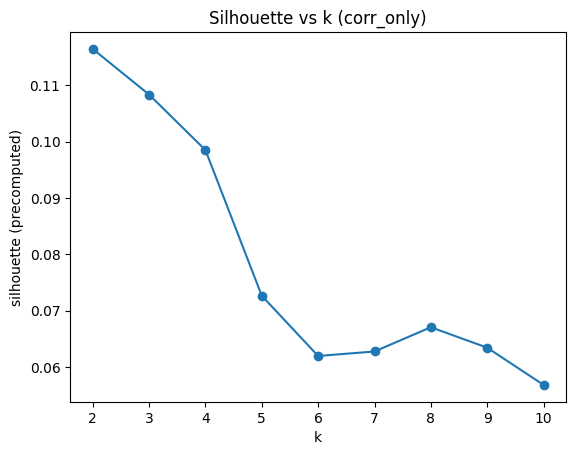

In [11]:
# 예: 큰 유니버스면 corr_only로 먼저 k 후보 잡기(가장 빠름)
X_scaled, D = make_distance_matrix(X_w, feature_names_w, mode="corr_only")  # 또는 X, feature_names
scores, labels_map, best_k = sweep_k_precomputed(D, k_min=2, k_max=10)

print(scores)
print("best_k:", best_k)
plot_k_scores(scores, "Silhouette vs k (corr_only)")


그 다음, best_k 주변만 DTW/hybrid로 정밀하게:

   silhouette  min_cluster_size
k                              
2    0.068554                 3
3    0.039764                 3
4    0.018739                 1
best_k_h: 2


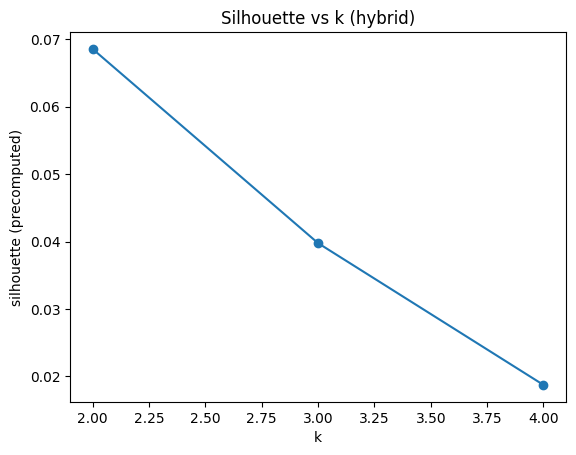

In [12]:
# hybrid로 정밀 (DTW 포함하므로 느려질 수 있음)
X_scaled_h, D_h = make_distance_matrix(
    X_w, feature_names_w,
    mode="hybrid",
    weights=(0.5, 0.4, 0.1),
    sakoe_chiba_radius=5   # 주간이면 5~10 정도로 충분히 빠름
)
scores_h, labels_map_h, best_k_h = sweep_k_precomputed(D_h, k_min=max(2, best_k-2), k_max=best_k+2)

print(scores_h)
print("best_k_h:", best_k_h)
plot_k_scores(scores_h, "Silhouette vs k (hybrid)")


Soft-DTW는 N이 크면 매우 무거우니(거리행렬 계산 자체가 빡셈) N이 30~60 이하 정도에서만 추천:

    silhouette  min_cluster_size
k                               
2     0.114367                 3
3     0.067434                 1
4     0.055642                 1
5     0.045368                 1
6     0.042056                 1
7     0.034175                 1
8     0.048720                 1
9     0.042694                 1
10    0.041724                 1


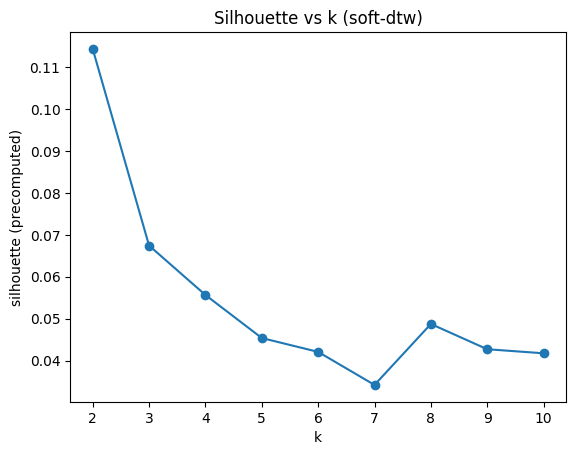

In [13]:
# softdtw (N이 작을 때만)
X_scaled_s, D_s = make_distance_matrix(X_w, feature_names_w, mode="softdtw", gamma=1.0)
scores_s, labels_map_s, best_k_s = sweep_k_precomputed(D_s, k_min=2, k_max=10)
print(scores_s)
plot_k_scores(scores_s, "Silhouette vs k (soft-dtw)")


# Step 36) 안정성 체크(간단/빠름): 기간을 반으로 나눠 ARI

- “최근 1년”을 앞 6개월 vs 뒤 6개월로 나눠서, 같은 방법으로 클러스터링했을 때 라벨이 얼마나 비슷한지(ARI) 봅니다.
- (라벨 번호는 클러스터마다 permutation이 있을 수 있지만 ARI는 permutation에 강합니다.)

In [14]:
from sklearn.metrics import adjusted_rand_score

def half_split_ari(
    feat_panel: pd.DataFrame,
    tickers: list[str],
    mode: str,
    feature_names: list[str] | None = None,
    k: int = 4,
    use_weekly: bool = True,
    gamma: float = 1.0,
    weights=(0.5,0.4,0.1),
    sakoe_chiba_radius: int | None = 5
) -> float:
    # 공통 날짜 기준으로 텐서 만들기 위해 먼저 slice는 동일하게
    dates_all = feat_panel.index.get_level_values("date").unique().sort_values()
    mid = len(dates_all) // 2
    d1 = dates_all[:mid]
    d2 = dates_all[mid:]

    fp1 = feat_panel.loc[(d1, slice(None)), :]
    fp2 = feat_panel.loc[(d2, slice(None)), :]

    if use_weekly:
        fp1 = resample_feature_panel_weekly(fp1, how="last")
        fp2 = resample_feature_panel_weekly(fp2, how="last")

    X1, _, fn1 = build_tensor(fp1, tickers)
    X2, _, fn2 = build_tensor(fp2, tickers)
    # feature_names는 panel에서 나온 걸 쓰면 됨
    fn = fn1

    _, D1 = make_distance_matrix(X1, fn, mode=mode, gamma=gamma, weights=weights, sakoe_chiba_radius=sakoe_chiba_radius)
    _, D2 = make_distance_matrix(X2, fn, mode=mode, gamma=gamma, weights=weights, sakoe_chiba_radius=sakoe_chiba_radius)

    lab1 = agglom_from_precomputed(D1, min(k, len(tickers)-1))
    lab2 = agglom_from_precomputed(D2, min(k, len(tickers)-1))

    return float(adjusted_rand_score(lab1, lab2))

# 예: hybrid 안정성
ari_h = half_split_ari(feat_1y, tickers, mode="hybrid", k=best_k_h, use_weekly=True, sakoe_chiba_radius=5)
print("Half-split ARI (hybrid):", ari_h)

# 예: corr_only 안정성
ari_c = half_split_ari(feat_1y, tickers, mode="corr_only", k=best_k, use_weekly=True)
print("Half-split ARI (corr_only):", ari_c)


Half-split ARI (hybrid): 0.0008532581476878559
Half-split ARI (corr_only): -0.020809406085145317


# Step 37) 최종 리포트(CSV) 만들기: 라벨 + 요약 통계 + 메도이드

거리기반(계층적)에서는 메도이드(대표 종목) 가 해석에 정말 좋습니다.

In [16]:
def cluster_medoids(D: np.ndarray, labels: np.ndarray, tickers: list[str]):
    medoids = {}
    for c in np.unique(labels):
        idx = np.where(labels == c)[0]
        Dc = D[np.ix_(idx, idx)]
        avg_dist = Dc.mean(axis=1)
        m = idx[int(np.argmin(avg_dist))]
        medoids[int(c)] = tickers[m]
    return medoids

def make_report(X_scaled: np.ndarray, feature_names: list[str], tickers: list[str], labels: np.ndarray, medoids: dict):
    summary = pd.DataFrame(X_scaled.mean(axis=1), index=tickers, columns=feature_names)
    out = summary.copy()
    out["cluster"] = labels
    out["cluster_medoid"] = pd.Series(labels, index=tickers).map(medoids)
    return out.sort_values("cluster")

# 최종 선택 예: hybrid
labels_final = labels_map_h[best_k_h]
med = cluster_medoids(D_h, labels_final, tickers)

report = make_report(X_scaled_h, feature_names_w, tickers, labels_final, med)
report.to_csv("final_timeseries_clusters_hybrid.csv", encoding="utf-8-sig")

display(report.head(20))
print("Saved: final_timeseries_clusters_hybrid.csv")


,log_ret,roll_mean,roll_vol,roll_mdd,cum_logret,trend_slope,cluster,cluster_medoid
000100.KS,3.965082e-17,-3.841173e-17,-3.846130e-16,-4.698622e-16,5.204170e-18,-1.189525e-17,0,086790.KS
000150.KS,3.283584e-18,1.214306e-17,1.808077e-15,-6.086401e-16,1.090398e-17,3.172066e-17,0,086790.KS
000270.KS,3.469447e-18,2.577303e-17,7.771561e-16,2.894510e-16,-2.998593e-17,-7.831037e-17,0,086790.KS
000660.KS,4.361590e-17,1.586033e-17,-3.608225e-16,2.735907e-16,-1.030921e-16,-5.947623e-17,0,086790.KS
000720.KS,-5.947623e-18,3.766828e-17,-1.037860e-15,-8.326673e-17,7.831037e-17,1.610815e-16,0,086790.KS
000810.KS,1.288652e-17,2.973812e-18,1.566207e-16,-2.894510e-16,2.973812e-18,-3.419883e-17,0,086790.KS
003230.KS,-9.912706e-19,-1.318390e-16,-3.142328e-16,-6.145877e-17,2.081668e-17,-1.268826e-16,0,086790.KS
003490.KS,-2.354268e-18,1.586033e-17,-4.976178e-16,-7.305664e-16,2.577303e-17,-5.352861e-17,0,086790.KS
003550.KS,3.965082e-18,-8.326673e-17,-5.273559e-16,-2.438526e-16,6.938894e-17,2.255141e-17,0,086790.KS
003670.KS,-1.982541e-18,-3.965082e-18,-1.982541e-16,1.090398e-17,-6.344132e-17,8.723181e-17,0,086790.KS


Saved: final_timeseries_clusters_hybrid.csv


좋아요. 이제 실무에서 가장 많이 쓰는 2-stage clustering(2단계 군집화) 를 이어서 진행하겠습니다.

핵심 아이디어는 이거예요:

1단계(거칠게, 빠르게): 모든 종목을 corr_only 같은 가벼운 거리로 크게 묶기

2단계(정밀하게, 느리지만 정확): 1단계에서 같은 그룹으로 묶인 종목들 안에서만 hybrid(상관+DTW) 또는 soft-DTW로 세분화


아래 코드는 “처음부터 끝까지” 돌아가는 완성형 2-stage 템플릿입니다.
(요청하신 대로 피쳐에 log_ret 포함되어 있습니다.)

In [18]:
import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import cdist_dtw


# =========================
# 1) Feature 만들기 (log_ret 포함)
# =========================
def rolling_mdd_from_logrets(arr: np.ndarray) -> float:
    arr = arr[~np.isnan(arr)]
    if arr.size < 2:
        return np.nan
    cum = np.exp(arr).cumprod()
    peak = np.maximum.accumulate(cum)
    dd = cum / peak - 1.0
    return float(dd.min())

def rolling_slope(series: pd.Series, window: int) -> pd.Series:
    idx = np.arange(window)

    def slope_fn(v: np.ndarray) -> float:
        if np.any(np.isnan(v)):
            return np.nan
        x0 = idx - idx.mean()
        y0 = v - v.mean()
        denom = (x0**2).sum()
        return float((x0 * y0).sum() / denom) if denom != 0 else 0.0

    return series.rolling(window).apply(slope_fn, raw=True)

def make_feature_panel(prices: pd.DataFrame, window: int = 10, add_optional: bool = True) -> pd.DataFrame:
    lr = np.log(prices).diff()

    feats = {
        "log_ret": lr,  # 요청: 로그수익률 포함
        "roll_mean": lr.rolling(window, min_periods=window).mean(),
        "roll_vol": lr.rolling(window, min_periods=window).std(),
        "roll_mdd": lr.rolling(window, min_periods=window).apply(rolling_mdd_from_logrets, raw=True),
    }

    if add_optional:
        feats["cum_logret"] = lr.rolling(window, min_periods=window).sum()
        logp = np.log(prices)
        feats["trend_slope"] = logp.apply(lambda s: rolling_slope(s, window))

    panel = pd.concat(feats, axis=1)      # columns: (feature, ticker)
    panel = panel.stack(level=1)          # index: (date, ticker)
    panel.index.names = ["date", "ticker"]
    return panel.dropna()

def slice_last_n_dates(feat_panel: pd.DataFrame, n: int) -> pd.DataFrame:
    dates = feat_panel.index.get_level_values("date").unique().sort_values()
    last_dates = dates[-n:]
    return feat_panel.loc[(last_dates, slice(None)), :]

def resample_feature_panel_weekly(feat_panel: pd.DataFrame, how: str = "last") -> pd.DataFrame:
    df = feat_panel.copy()

    # date 레벨을 datetime으로 보장
    df = df.reset_index()
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index(["date", "ticker"]).sort_index()

    rs = df.groupby(level="ticker").resample("W-FRI", level="date")

    if how == "last":
        out = rs.last()
    elif how == "mean":
        out = rs.mean()
    else:
        raise ValueError('how must be "last" or "mean"')

    # (ticker, date) -> (date, ticker) 순서로 정리
    out = out.swaplevel(0, 1).sort_index()
    return out.dropna()


def build_tensor(feat_panel: pd.DataFrame, tickers: list[str]) -> tuple[np.ndarray, pd.DatetimeIndex, list[str]]:
    common_dates = None
    for t in tickers:
        idx = feat_panel.xs(t, level="ticker").index
        common_dates = idx if common_dates is None else common_dates.intersection(idx)
    common_dates = common_dates.sort_values()

    mats = []
    for t in tickers:
        mats.append(feat_panel.xs(t, level="ticker").loc[common_dates].values)  # (T,F)
    X = np.stack(mats, axis=0)  # (N,T,F)

    return X, common_dates, list(feat_panel.columns)


# =========================
# 2) 거리행렬 & 클러스터링 유틸
# =========================
def agglom_from_precomputed(D: np.ndarray, k: int) -> np.ndarray:
    try:
        model = AgglomerativeClustering(n_clusters=k, metric="precomputed", linkage="average")
    except TypeError:
        model = AgglomerativeClustering(n_clusters=k, affinity="precomputed", linkage="average")
    return model.fit_predict(D)

def corr_distance_matrix_for_feature(X_scaled: np.ndarray, f_idx: int) -> np.ndarray:
    # X_scaled: (N,T,F)
    A = X_scaled[:, :, f_idx]  # (N,T)
    C = np.corrcoef(A)
    D = 1.0 - C
    np.fill_diagonal(D, 0.0)
    # 상수시계열 등으로 NaN 나올 수 있어 보정
    D = np.nan_to_num(D, nan=1.0, posinf=1.0, neginf=1.0)
    return D

def corr_only_distance(X_scaled: np.ndarray) -> np.ndarray:
    # 모든 피쳐의 상관거리 평균
    F = X_scaled.shape[2]
    Ds = [corr_distance_matrix_for_feature(X_scaled, f) for f in range(F)]
    D = np.mean(Ds, axis=0)
    np.fill_diagonal(D, 0.0)
    return D

def hybrid_distance(
    X_scaled: np.ndarray,
    feature_names: list[str],
    weights=(0.5, 0.4, 0.1),            # (ret, risk, trend)
    sakoe_chiba_radius: int | None = 5  # DTW 속도옵션(제약), None이면 full DTW
) -> np.ndarray:
    fmap = {n: i for i, n in enumerate(feature_names)}
    N = X_scaled.shape[0]
    w_ret, w_risk, w_trend = weights

    ret_like = [x for x in ["log_ret", "roll_mean", "cum_logret"] if x in fmap]
    risk_like = [x for x in ["roll_vol", "roll_mdd"] if x in fmap]
    trend_like = [x for x in ["trend_slope"] if x in fmap]

    D_mix = np.zeros((N, N), dtype=float)

    # (A) return/momentum: correlation distance
    if ret_like:
        D_ret = np.mean([corr_distance_matrix_for_feature(X_scaled, fmap[n]) for n in ret_like], axis=0)
        D_mix += w_ret * D_ret

    # (B) risk: DTW on selected risk features (multivariate)
    if risk_like:
        X_sub = X_scaled[:, :, [fmap[n] for n in risk_like]]  # (N,T,D)
        if sakoe_chiba_radius is not None:
            D_risk = cdist_dtw(
                X_sub,
                global_constraint="sakoe_chiba",
                sakoe_chiba_radius=sakoe_chiba_radius
            )
        else:
            D_risk = cdist_dtw(X_sub)
        np.fill_diagonal(D_risk, 0.0)
        D_mix += w_risk * D_risk

    # (C) trend: correlation distance
    if trend_like:
        D_tr = corr_distance_matrix_for_feature(X_scaled, fmap[trend_like[0]])
        D_mix += w_trend * D_tr

    np.fill_diagonal(D_mix, 0.0)
    return D_mix

def sweep_k(D: np.ndarray, k_min=2, k_max=10, min_cluster_size: int = 5):
    n = D.shape[0]
    k_max = min(k_max, n - 1)
    rows = []
    labels_map = {}

    for k in range(k_min, k_max + 1):
        labels = agglom_from_precomputed(D, k)
        vc = pd.Series(labels).value_counts()
        if vc.min() < min_cluster_size:
            continue
        sil = silhouette_score(D, labels, metric="precomputed")
        rows.append({"k": k, "silhouette": sil, "min_cluster_size": int(vc.min())})
        labels_map[k] = labels

    if not rows:
        return pd.DataFrame(columns=["silhouette", "min_cluster_size"]), {}, None

    score_df = pd.DataFrame(rows).set_index("k").sort_index()
    best_k = int(score_df["silhouette"].idxmax())
    return score_df, labels_map, best_k

def cluster_medoids(D: np.ndarray, labels: np.ndarray, items: list[str]) -> dict[int, str]:
    medoids = {}
    for c in np.unique(labels):
        idx = np.where(labels == c)[0]
        Dc = D[np.ix_(idx, idx)]
        avg_dist = Dc.mean(axis=1)
        m = idx[int(np.argmin(avg_dist))]
        medoids[int(c)] = items[m]
    return medoids


# =========================
# 3) 2-stage 클러스터링 본체
# =========================
def two_stage_clustering(
    prices: pd.DataFrame,
    tickers: list[str],
    window: int = 10,
    lookback_days: int = 252,
    weekly: bool = True,
    stage1_mode: str = "corr_only",       # "corr_only" 추천
    stage2_mode: str = "hybrid",          # "hybrid" 추천 (DTW 포함)
    stage1_k_range=(2, 10),
    stage2_k_range=(2, 8),
    stage1_min_cluster_size: int = 10,
    stage2_min_cluster_size: int = 5,
    hybrid_weights=(0.5, 0.4, 0.1),
    sakoe_chiba_radius: int | None = 5
):
    # ---- features ----
    feat_panel = make_feature_panel(prices, window=window, add_optional=True)
    feat_panel = slice_last_n_dates(feat_panel, lookback_days)
    if weekly:
        feat_panel = resample_feature_panel_weekly(feat_panel, how="last")

    X, dates, feature_names = build_tensor(feat_panel, tickers)

    # scale for time-series distances
    X_scaled = TimeSeriesScalerMeanVariance().fit_transform(X)

    # ---- Stage 1 distance ----
    if stage1_mode != "corr_only":
        raise ValueError("stage1_mode currently supports 'corr_only' only (fast baseline).")

    D1 = corr_only_distance(X_scaled)

    # ---- Stage 1 choose k ----
    s1_min, s1_max = stage1_k_range
    scores1, labels_map1, best_k1 = sweep_k(D1, k_min=s1_min, k_max=s1_max, min_cluster_size=stage1_min_cluster_size)
    if best_k1 is None:
        # fallback: 가장 작은 k로라도 진행
        best_k1 = max(2, min(3, len(tickers) - 1))
        labels1 = agglom_from_precomputed(D1, best_k1)
        scores1 = pd.DataFrame()
    else:
        labels1 = labels_map1[best_k1]

    # Stage1 medoids
    med1 = cluster_medoids(D1, labels1, tickers)

    # ---- Stage 2 (within each Stage1 cluster) ----
    stage2_labels_global = pd.Series(index=tickers, dtype="object")
    stage2_medoids_global = {}

    for c1 in np.unique(labels1):
        members = [tickers[i] for i in np.where(labels1 == c1)[0]]
        idx = np.where(labels1 == c1)[0]
        n_sub = len(idx)

        # 너무 작은 그룹은 Stage2 생략
        if n_sub < max(stage2_min_cluster_size, 2):
            for t in members:
                stage2_labels_global.loc[t] = f"{int(c1)}.-1"
            stage2_medoids_global[int(c1)] = { -1: med1[int(c1)] }
            continue

        X_sub = X_scaled[idx]  # (n_sub, T, F)

        # Stage2 distance
        if stage2_mode == "hybrid":
            D2 = hybrid_distance(
                X_sub, feature_names,
                weights=hybrid_weights,
                sakoe_chiba_radius=sakoe_chiba_radius
            )
        elif stage2_mode == "corr_only":
            D2 = corr_only_distance(X_sub)
        else:
            raise ValueError("stage2_mode supports: 'hybrid' or 'corr_only'.")

        # choose k2 (cluster size 고려)
        k2_min, k2_max = stage2_k_range
        k2_max = min(k2_max, n_sub - 1)
        scores2, labels_map2, best_k2 = sweep_k(D2, k_min=k2_min, k_max=k2_max, min_cluster_size=stage2_min_cluster_size)

        if best_k2 is None:
            best_k2 = 2 if n_sub >= 2 else 1
            labels2 = agglom_from_precomputed(D2, min(best_k2, n_sub - 1))
            scores2 = pd.DataFrame()
        else:
            labels2 = labels_map2[best_k2]

        # medoids within stage2 clusters
        med2 = cluster_medoids(D2, labels2, members)
        stage2_medoids_global[int(c1)] = med2

        for j, t in enumerate(members):
            stage2_labels_global.loc[t] = f"{int(c1)}.{int(labels2[j])}"

    # ---- report ----
    report = pd.DataFrame(index=tickers)
    report["stage1"] = labels1
    report["stage1_medoid"] = pd.Series(labels1, index=tickers).map(med1)

    report["final_cluster"] = stage2_labels_global

    # final cluster medoid (stage2 기준): 각 최종클러스터에서 대표 종목 찍기
    # 여기서는 stage2_medoids_global을 활용해 매핑만 합니다.
    def final_medoid(row):
        c1 = int(row["stage1"])
        c2 = int(str(row["final_cluster"]).split(".")[1])
        return stage2_medoids_global.get(c1, {}).get(c2, row["stage1_medoid"])

    report["final_medoid"] = report.apply(final_medoid, axis=1)

    # 해석용: 종목별 피쳐 평균(시간평균)
    summary = pd.DataFrame(X_scaled.mean(axis=1), index=tickers, columns=feature_names)
    report = report.join(summary)

    return {
        "report": report.sort_values(["stage1", "final_cluster"]),
        "scores_stage1": scores1,
        "best_k1": best_k1,
        "dates_used": dates,
        "feature_names": feature_names,
    }


# =========================
# 4) 실행 예시
# =========================
# tickers는 많을수록 좋습니다(20~200 추천)
tickers = ["005930.KS", "000660.KS", "105560.KS", "005380.KS", "402340.KS", "034020.KS", "035420.KS", "012450.KS", "055550.KS", "068270.KS", "000270.KS", "028260.KS", "086790.KS", "012330.KS", "035720.KS", "005490.KS", "267260.KS", "009540.KS", "373220.KS", "316140.KS", "207940.KS", "329180.KS", "006400.KS", "010140.KS", "042660.KS", "015760.KS", "000810.KS", "009150.KS", "051910.KS", "064350.KS", "032830.KS", "033780.KS", "030200.KS", "066570.KS", "034730.KS", "047810.KS", "267250.KS", "010120.KS", "138040.KS", "010130.KS", "298040.KS", "017670.KS", "096770.KS", "323410.KS", "003550.KS", "259960.KS", "352820.KS", "042700.KS", "071050.KS", "006800.KS", "000100.KS", "086280.KS", "018260.KS", "003670.KS", "011200.KS", "003490.KS", "079550.KS", "180640.KS", "024110.KS", "005830.KS", "000720.KS", "003230.KS", "000150.KS", "016360.KS", "021240.KS", "0126Z0.KS", "161390.KS", "272210.KS", "011070.KS", "032640.KS", "028050.KS", "090430.KS", "036570.KS", "010950.KS", "034220.KS", "326030.KS", "005940.KS", "241560.KS", "128940.KS", "009830.KS", "078930.KS", "443060.KS", "004020.KS", "011790.KS", "047050.KS", "051900.KS", "035250.KS", "271560.KS", "097950.KS", "454910.KS", "011780.KS", "251270.KS", "022100.KS", "029780.KS", "036460.KS", "450080.KS", "377300.KS", "011170.KS", "302440.KS", "004990.KS"]

prices = yf.download(tickers, start="2022-01-01", auto_adjust=True, progress=False)["Close"].dropna(how="all")

# 2-stage 실행
res = two_stage_clustering(
    prices=prices,
    tickers=tickers,
    window=10,
    lookback_days=252,        # 최근 1년
    weekly=True,              # 속도/안정성 위해 주간 권장
    stage1_k_range=(2, 10),
    stage2_k_range=(2, 6),
    stage1_min_cluster_size=2,   # 예시 tickers가 5개라서 데모에서는 2로 낮춤
    stage2_min_cluster_size=2,
    stage2_mode="hybrid",
    hybrid_weights=(0.5, 0.4, 0.1),
    sakoe_chiba_radius=5
)

print("Stage1 k scores:\n", res["scores_stage1"])
print("Best k1:", res["best_k1"])
print("\nFinal report:\n", res["report"])

# 저장
res["report"].to_csv("two_stage_timeseries_clusters.csv", encoding="utf-8-sig")
print("\nSaved: two_stage_timeseries_clusters.csv")


/tmp/ipykernel_13562/1279205415.py:52: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  panel = panel.stack(level=1)          # index: (date, ticker)


Stage1 k scores:
    silhouette  min_cluster_size
k                              
2    0.286497                15
3    0.301137                15
4    0.224067                 2
5    0.256797                 2
Best k1: 3

Final report:
            stage1 stage1_medoid final_cluster final_medoid       log_ret  \
015760.KS       0     032640.KS           0.0    032640.KS -5.551115e-17   
032830.KS       0     032640.KS           0.0    032640.KS  4.440892e-17   
016360.KS       0     032640.KS           0.0    032640.KS -4.440892e-17   
032640.KS       0     032640.KS           0.0    032640.KS  4.440892e-17   
028050.KS       0     032640.KS           0.0    032640.KS -2.775558e-18   
...           ...           ...           ...          ...           ...   
004020.KS       2     329180.KS           2.1    000720.KS -2.220446e-17   
047050.KS       2     329180.KS           2.1    000720.KS  4.440892e-17   
454910.KS       2     329180.KS           2.1    000720.KS  0.000000e+00   
029

# Step 38) (중요) “규모”에 맞춘 권장 설정

* 종목 수 N이 100 이상이면:
    - weekly=True 강추 (T를 줄여 DTW 계산이 크게 빨라짐)
    - sakoe_chiba_radius=5~10 권장 (제약 DTW로 속도 개선)
    - 2단계는 hybrid 추천(리스크만 DTW, 나머지는 상관거리)
* 종목 수가 매우 크면(300~1000):
    - 1단계는 corr_only로 큰 덩어리 만든 뒤
    - 2단계는 “관심 있는 덩어리”만 골라서 hybrid/softdtw 적용

# Step 39) (추가) 2-stage 결과가 “기간을 바꿔도 유지되는지” 빠르게 점검

아래는 “최근 1년 vs 최근 2년”에서 최종 라벨이 비슷한지(ARI) 보는 예시입니다.

In [19]:
def final_label_to_int(series: pd.Series) -> np.ndarray:
    # "c1.c2" 문자열을 정수로 변환(단순 매핑)
    cats = pd.Categorical(series.astype(str))
    return cats.codes

# 1년
res1 = two_stage_clustering(prices, tickers, lookback_days=252, weekly=True,
                           stage1_min_cluster_size=2, stage2_min_cluster_size=2)
lab1 = final_label_to_int(res1["report"]["final_cluster"])

# 2년
res2 = two_stage_clustering(prices, tickers, lookback_days=504, weekly=True,
                           stage1_min_cluster_size=2, stage2_min_cluster_size=2)
lab2 = final_label_to_int(res2["report"]["final_cluster"])

print("ARI(final, 1y vs 2y) =", adjusted_rand_score(lab1, lab2))


/tmp/ipykernel_13562/1279205415.py:52: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  panel = panel.stack(level=1)          # index: (date, ticker)
/tmp/ipykernel_13562/1279205415.py:52: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  panel = panel.stack(level=1)          # index: (date, ticker)


ARI(final, 1y vs 2y) = 1.0


# Step 40) 2-stage 결과에서 “클러스터별 멤버/대표종목(메도이드)” 정리

In [20]:
import numpy as np
import pandas as pd

report = res["report"].copy()
dates_used = res["dates_used"]
feature_names = res["feature_names"]

# 최종 클러스터(문자열: "c1.c2")별로 종목 리스트
cluster_members = report.groupby("final_cluster").apply(lambda df: df.index.tolist()).to_dict()

# 최종 클러스터별 대표 종목(메도이드): report["final_medoid"]가 있으므로
cluster_medoid = report.groupby("final_cluster")["final_medoid"].first().to_dict()

print("Number of final clusters:", len(cluster_members))
for c, mem in list(cluster_members.items())[:10]:
    print(c, "size=", len(mem), "medoid=", cluster_medoid.get(c))


Number of final clusters: 7
0.0 size= 7 medoid= 032640.KS
0.1 size= 7 medoid= 030200.KS
0.2 size= 5 medoid= 011780.KS
1.0 size= 12 medoid= 086790.KS
1.1 size= 3 medoid= 352820.KS
2.0 size= 32 medoid= 022100.KS
2.1 size= 34 medoid= 000720.KS


/tmp/ipykernel_13562/1477201051.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_members = report.groupby("final_cluster").apply(lambda df: df.index.tolist()).to_dict()


# Step 41) “클러스터별 대표 패턴(피쳐별 시계열)” 자동 플롯 만들기

여기서 핵심은: 각 종목의 피쳐 시계열(T×F)을 다시 꺼내서
클러스터 단위로 평균 궤적을 그리는 겁니다.

> 주의: two_stage_clustering 내부에서 TimeSeriesScalerMeanVariance()로 정규화한 값 기준으로 요약치를 만들었습니다.
> - 즉 그래프는 “표준화된(스케일 제거된) 패턴 비교”입니다.

## 41-1) 리포트와 동일한 기간/주기(weekly 여부)로 feature panel 다시 만들고 텐서 구축

(가장 안전한 방법: 리포트에서 사용한 것과 같은 로직으로 다시 생성)

In [21]:
# two_stage_clustering와 동일한 설정을 써야 합니다.
# (아래 변수들은 사용자가 two_stage_clustering 호출할 때 썼던 값과 맞추세요)
WINDOW = 10
LOOKBACK_DAYS = 252
WEEKLY = True

feat_panel_r = make_feature_panel(prices, window=WINDOW, add_optional=True)
feat_panel_r = slice_last_n_dates(feat_panel_r, LOOKBACK_DAYS)
if WEEKLY:
    feat_panel_r = resample_feature_panel_weekly(feat_panel_r, how="last")

# 텐서 (N,T,F)
tickers_used = report.index.tolist()
X_raw, dates_r, feat_names_r = build_tensor(feat_panel_r, tickers_used)

# 리포트/분석은 스케일이 중요하므로 동일하게 스케일
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
X_scaled = TimeSeriesScalerMeanVariance().fit_transform(X_raw)

assert list(feat_names_r) == list(feature_names), "feature_names mismatch: 설정(WINDOW/weekly/add_optional)을 확인하세요."
print("X_scaled:", X_scaled.shape, "dates:", len(dates_r))


X_scaled: (100, 5, 6) dates: 5


/tmp/ipykernel_13562/1279205415.py:52: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  panel = panel.stack(level=1)          # index: (date, ticker)


## 41-2) 클러스터 평균 궤적 + 메도이드 궤적 함께 그리기

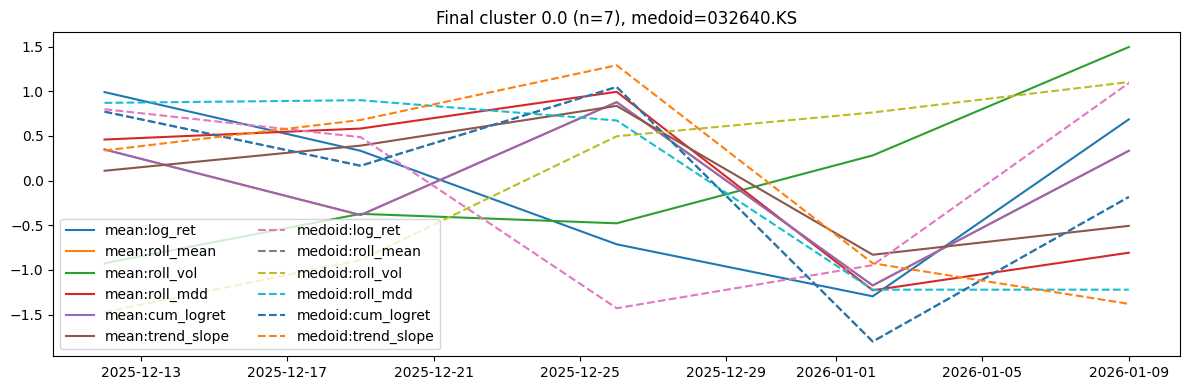

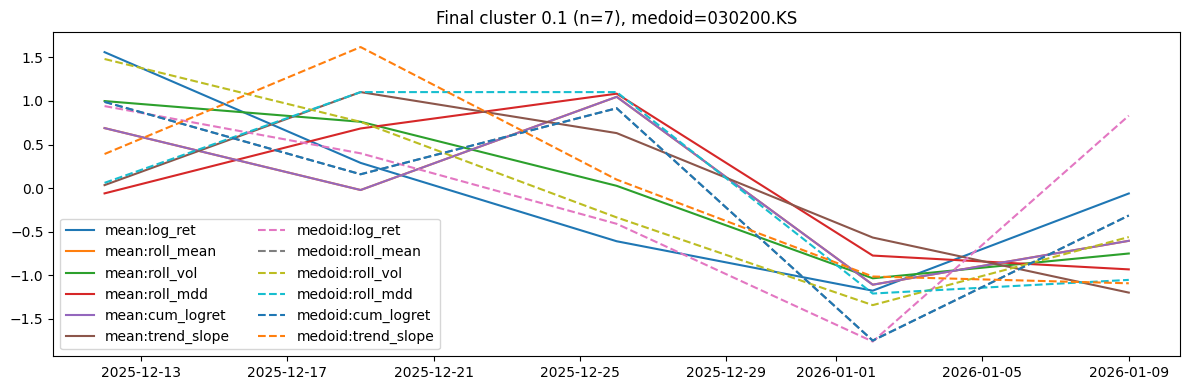

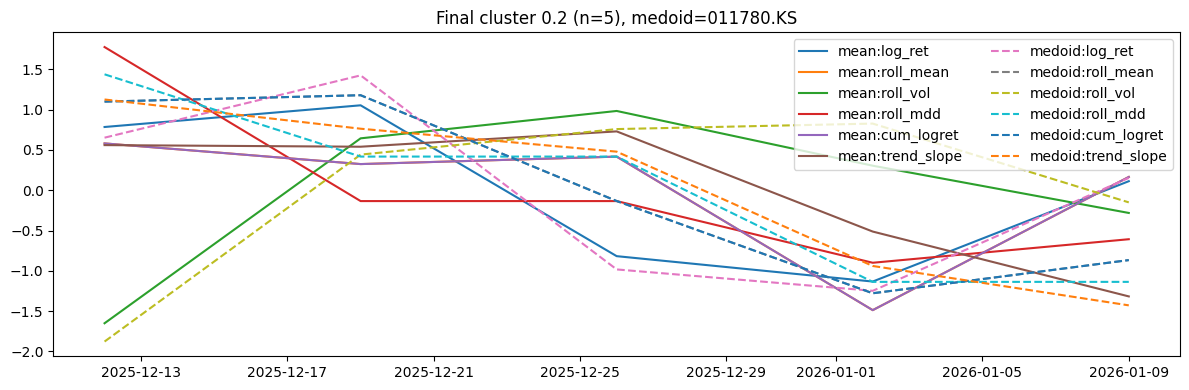

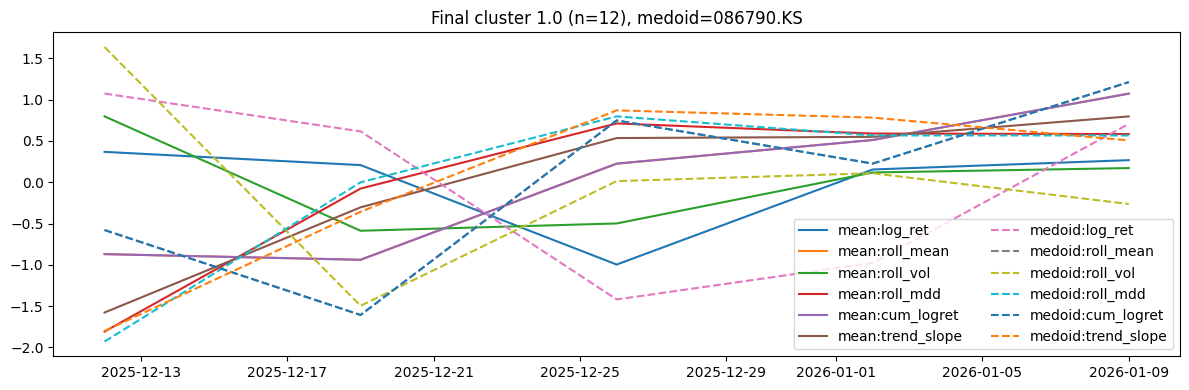

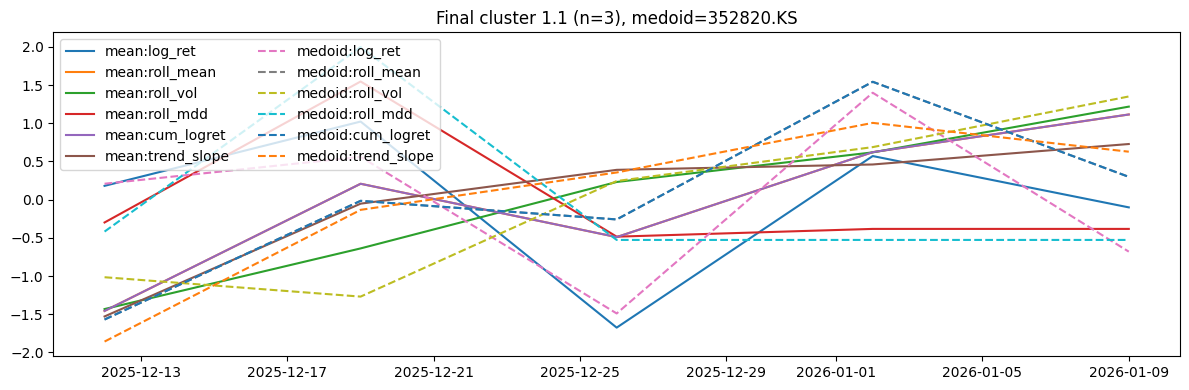

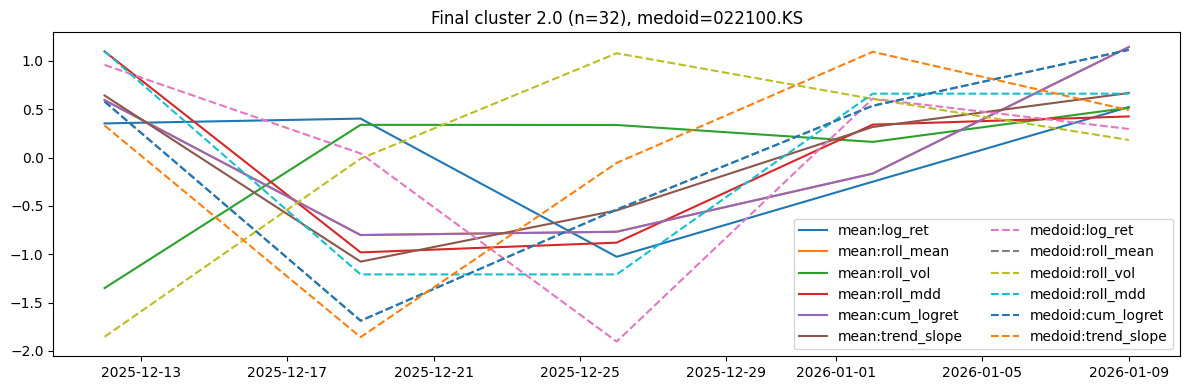

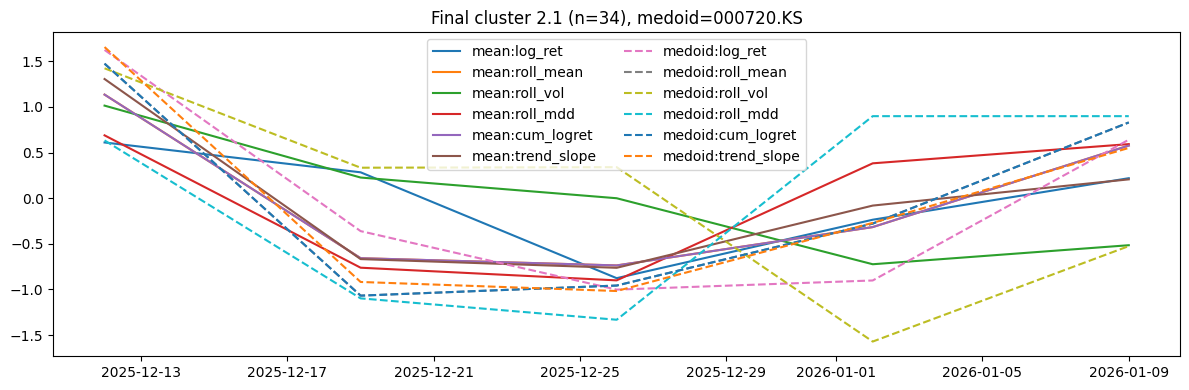

In [22]:
import matplotlib.pyplot as plt

ticker_to_i = {t:i for i,t in enumerate(tickers_used)}

def plot_cluster_trajectories(cluster_id: str, save_path: str | None = None):
    members = cluster_members[cluster_id]
    idx = [ticker_to_i[t] for t in members]
    mean_traj = X_scaled[idx].mean(axis=0)  # (T,F)

    med = cluster_medoid.get(cluster_id)
    med_traj = X_scaled[ticker_to_i[med]] if med in ticker_to_i else None

    plt.figure(figsize=(12, 4))
    for f, name in enumerate(feature_names):
        plt.plot(dates_r, mean_traj[:, f], label=f"mean:{name}")
    if med_traj is not None:
        for f, name in enumerate(feature_names):
            plt.plot(dates_r, med_traj[:, f], linestyle="--", label=f"medoid:{name}")

    plt.title(f"Final cluster {cluster_id} (n={len(members)}), medoid={med}")
    plt.legend(ncol=2)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

# 예: 모든 클러스터를 파일로 저장 + 화면 출력
import os
os.makedirs("cluster_plots", exist_ok=True)

for cid in sorted(cluster_members.keys()):
    plot_cluster_trajectories(cid, save_path=f"cluster_plots/cluster_{cid}.png")


# Step 42) “클러스터별 요약표(프로파일)” 자동 생성

## 42-1) 종목별 시계열을 시간평균해서 (종목×피쳐) 요약
(클러스터 해석을 위해 가장 많이 씁니다)

In [24]:
# 종목별 시간평균 요약(표준화된 값)
ticker_profile = pd.DataFrame(
    X_scaled.mean(axis=1),  # (N,F)
    index=tickers_used,
    columns=feature_names
)

profile_with_cluster = ticker_profile.join(report[["final_cluster", "final_medoid", "stage1", "stage1_medoid"]])
cluster_profile = profile_with_cluster.groupby("final_cluster")[feature_names].mean()

display(cluster_profile)
cluster_profile.to_csv("cluster_profile_mean.csv", encoding="utf-8-sig")
print("Saved: cluster_profile_mean.csv")


,log_ret,roll_mean,roll_vol,roll_mdd,cum_logret,trend_slope
final_cluster,,,,,,
0.0,4.361590e-18,4.837400e-17,-8.881784e-17,-5.709718e-17,3.409971e-17,7.632783e-18
0.1,-1.427430e-17,-6.542386e-18,7.612958e-17,3.172066e-17,1.665335e-17,-1.903239e-17
0.2,2.664535e-17,2.498002e-16,3.663736e-17,1.387779e-18,-4.884981e-17,3.996803e-17
1.0,-2.046974e-17,9.251859e-19,1.277913e-16,-9.020562e-18,2.775558e-17,1.514992e-17
1.1,2.775558e-17,7.031412e-17,4.070818e-16,-6.106227e-17,3.330669e-17,-2.107111e-16
2.0,-2.602085e-19,-2.081668e-18,-1.814250e-16,9.627715e-18,-1.387779e-18,-1.929880e-17
2.1,9.224647e-18,-1.273491e-17,9.861393e-17,-1.214306e-18,5.877651e-18,1.900032e-17


Saved: cluster_profile_mean.csv


## 42-2) 각 클러스터에서 “가장 대표적인/가장 특이한” 종목 찾기

(클러스터 평균과의 거리로 랭킹)

In [25]:
import numpy as np

def top_representatives(cluster_id: str, top_n=5):
    members = cluster_members[cluster_id]
    sub = ticker_profile.loc[members]  # (n,F)
    center = sub.mean(axis=0).values
    dist = np.linalg.norm(sub.values - center, axis=1)

    out = pd.DataFrame({"ticker": sub.index, "dist_to_cluster_mean": dist}).sort_values("dist_to_cluster_mean")
    return out.head(top_n), out.tail(top_n)

for cid in sorted(cluster_members.keys()):
    best, worst = top_representatives(cid, top_n=3)
    print("\nCluster", cid, "best reps:\n", best)
    print("Cluster", cid, "most atypical:\n", worst)



Cluster 0.0 best reps:
       ticker  dist_to_cluster_mean
3  032640.KS          2.188480e-16
1  032830.KS          2.903386e-16
5  035250.KS          3.264040e-16
Cluster 0.0 most atypical:
       ticker  dist_to_cluster_mean
4  028050.KS          6.122178e-16
6  036460.KS          7.200384e-16
0  015760.KS          1.167971e-15

Cluster 0.1 best reps:
       ticker  dist_to_cluster_mean
5  097950.KS          1.179892e-16
3  161390.KS          1.959971e-16
2  021240.KS          3.770569e-16
Cluster 0.1 most atypical:
       ticker  dist_to_cluster_mean
0  030200.KS          4.677144e-16
6  004990.KS          6.143186e-16
1  024110.KS          1.001115e-15

Cluster 0.2 best reps:
       ticker  dist_to_cluster_mean
0  033780.KS          3.249154e-16
4  011170.KS          3.429978e-16
1  003490.KS          4.390698e-16
Cluster 0.2 most atypical:
       ticker  dist_to_cluster_mean
1  003490.KS          4.390698e-16
3  011780.KS          5.025321e-16
2  272210.KS          6.707563e-16



# Step 43) “왜 갈렸는지” 분석 1: 피쳐별 분리 기여도(간단/직관)

- 가장 쉬운 버전은 시간평균 요약값에서
    - 클러스터 간 평균 차이가 큰 피쳐가 “분리에 기여”했다고 보는 겁니다.

여기서는 ANOVA F-stat(효과 크기) 비슷한 지표를 계산합니다.

In [26]:
def feature_separation_score(profile: pd.DataFrame, labels: pd.Series) -> pd.Series:
    """
    profile: (N,F) numeric
    labels: length N cluster labels
    returns: separation score per feature (between_var / within_var)
    """
    scores = {}
    for col in profile.columns:
        x = profile[col]
        overall_mean = x.mean()
        groups = [x[labels == g] for g in labels.unique()]

        between = sum(len(g) * (g.mean() - overall_mean)**2 for g in groups)
        within = sum(((g - g.mean())**2).sum() for g in groups)
        scores[col] = float(between / (within + 1e-12))
    return pd.Series(scores).sort_values(ascending=False)

labels_series = report.loc[tickers_used, "final_cluster"]
sep_scores = feature_separation_score(ticker_profile, labels_series)

print("Feature separation (b/w):")
print(sep_scores)

sep_scores.to_csv("feature_separation_scores.csv", encoding="utf-8-sig")
print("Saved: feature_separation_scores.csv")


Feature separation (b/w):
roll_vol       2.177965e-18
roll_mean      3.331921e-19
trend_slope    1.701639e-19
roll_mdd       4.467067e-20
cum_logret     3.092891e-20
log_ret        1.491636e-20
dtype: float64
Saved: feature_separation_scores.csv


# Step 44) “왜 갈렸는지” 분석 2: 언제(어떤 시점)에 가장 갈렸는지(분리 시점 탐지)

이번엔 시간축까지 봅니다.
    
각 날짜/각 피쳐에서, 종목 간 변동 중 클러스터 간 차이(분산) 비중이 큰 날짜를 찾습니다.

## 44-1) 날짜별/피쳐별 “분리 점수” 계산

In [28]:
def separation_over_time(X_scaled: np.ndarray, labels: np.ndarray):
    """
    X_scaled: (N,T,F)
    labels: (N,)
    returns: sep_tf (T,F) where each is between_var / total_var
    """
    N, T, F = X_scaled.shape
    uniq = np.unique(labels)
    sep = np.zeros((T, F), dtype=float)

    for t in range(T):
        for f in range(F):
            x = X_scaled[:, t, f]
            overall_mean = x.mean()
            total = ((x - overall_mean)**2).sum() + 1e-12

            between = 0.0
            for g in uniq:
                idx = np.where(labels == g)[0]
                if idx.size == 0:
                    continue
                mg = x[idx].mean()
                between += idx.size * (mg - overall_mean)**2

            sep[t, f] = between / total
    return sep

# 최종 라벨을 N길이 배열로 만들기
labels_final = report.loc[tickers_used, "final_cluster"].astype(str).values

# 라벨을 정수로 인코딩(계산 편의)
label_codes = pd.Categorical(labels_final).codes

sep_tf = separation_over_time(X_scaled, label_codes)  # (T,F)
sep_df = pd.DataFrame(sep_tf, index=dates_r, columns=feature_names)

print(sep_df.tail())
sep_df.to_csv("separation_over_time.csv", encoding="utf-8-sig")
print("Saved: separation_over_time.csv")


             log_ret  roll_mean  roll_vol  roll_mdd  cum_logret  trend_slope
date                                                                        
2025-12-12  0.147094   0.446780  0.758146  0.629736    0.446780     0.585787
2025-12-19  0.081270   0.238548  0.217929  0.548767    0.238548     0.438093
2025-12-26  0.074292   0.640290  0.207877  0.729801    0.640290     0.601838
2026-01-02  0.195636   0.399916  0.320566  0.480534    0.399916     0.345657
2026-01-09  0.064441   0.322938  0.385408  0.413948    0.322938     0.457221
Saved: separation_over_time.csv


## 44-2) “분리가 가장 강했던 날짜 TOP” 뽑기 (피쳐별)

In [29]:
TOPK = 10
top_dates = {}

for feat in feature_names:
    top = sep_df[feat].sort_values(ascending=False).head(TOPK)
    top_dates[feat] = top

top_report = pd.concat(top_dates, axis=1)
print(top_report.head(TOPK))
top_report.to_csv("top_separation_dates_by_feature.csv", encoding="utf-8-sig")
print("Saved: top_separation_dates_by_feature.csv")


             log_ret  roll_mean  roll_vol  roll_mdd  cum_logret  trend_slope
date                                                                        
2025-12-12  0.147094   0.446780  0.758146  0.629736    0.446780     0.585787
2025-12-19  0.081270   0.238548  0.217929  0.548767    0.238548     0.438093
2025-12-26  0.074292   0.640290  0.207877  0.729801    0.640290     0.601838
2026-01-02  0.195636   0.399916  0.320566  0.480534    0.399916     0.345657
2026-01-09  0.064441   0.322938  0.385408  0.413948    0.322938     0.457221
Saved: top_separation_dates_by_feature.csv


## 44-3) 분리 점수 시계열 플롯

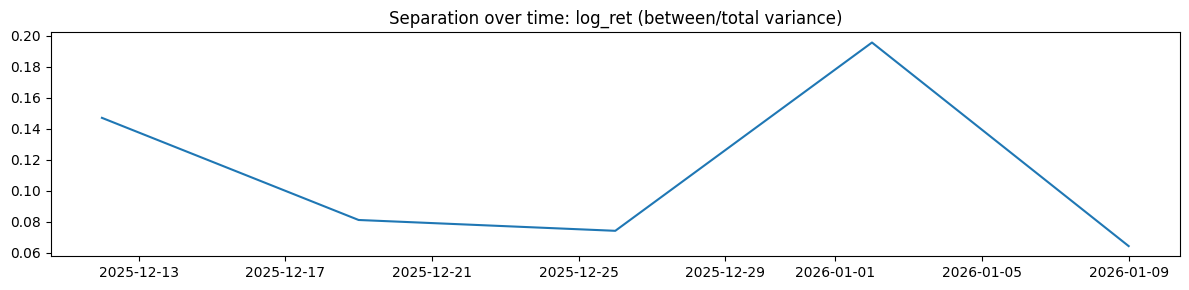

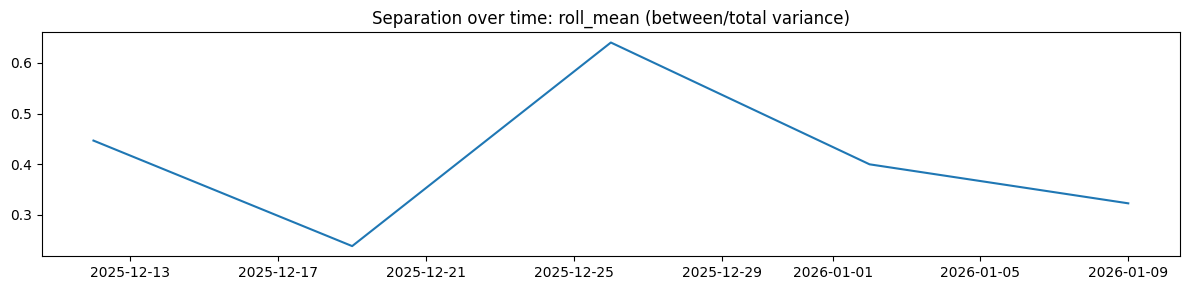

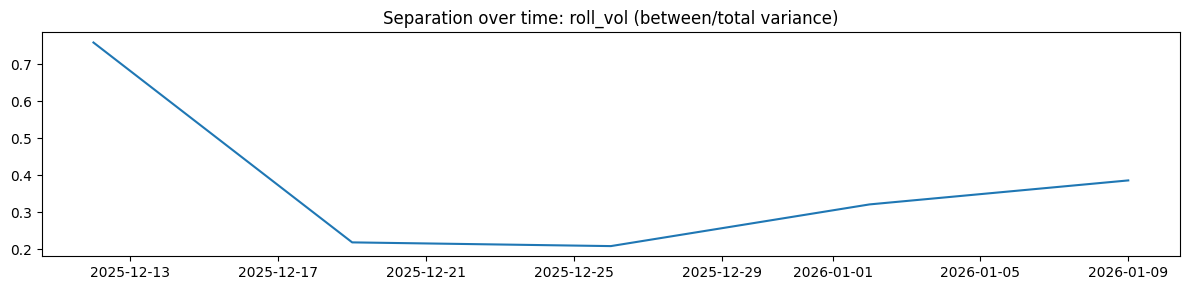

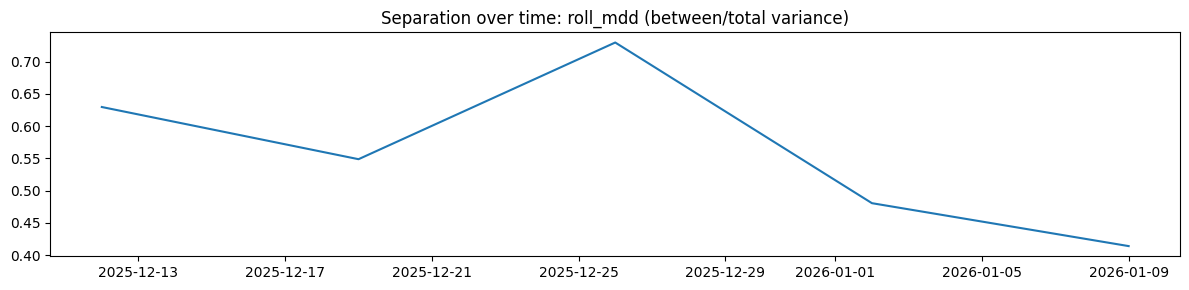

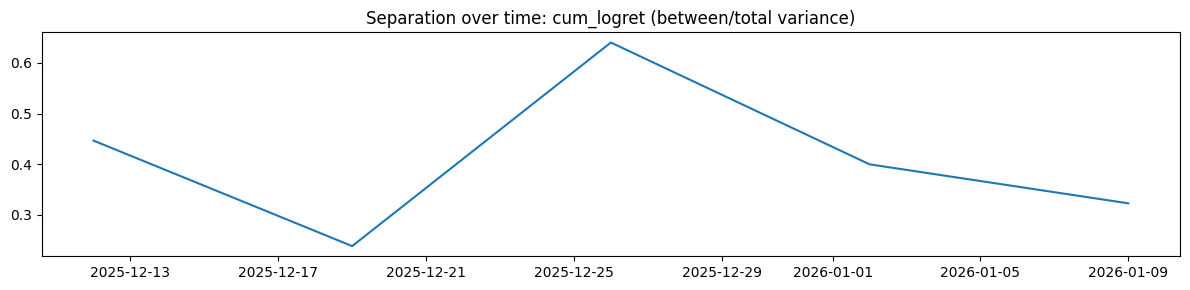

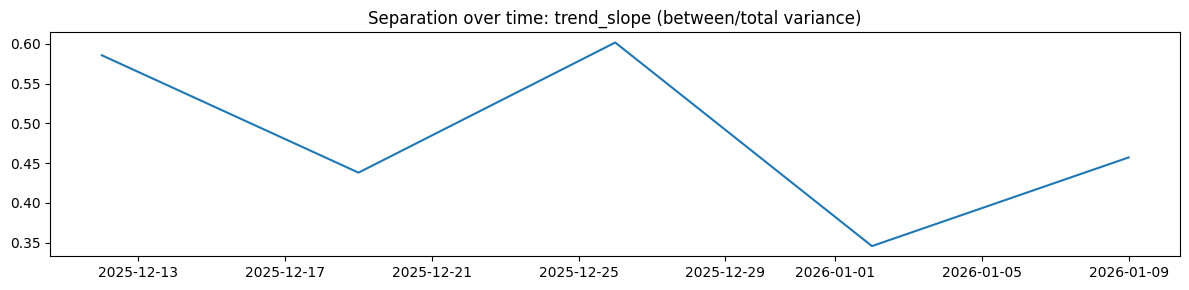

In [30]:
import matplotlib.pyplot as plt

for feat in feature_names:
    plt.figure(figsize=(12,3))
    plt.plot(sep_df.index, sep_df[feat])
    plt.title(f"Separation over time: {feat} (between/total variance)")
    plt.tight_layout()
    plt.show()


이걸 보면 “어느 구간에서 클러스터들이 확 갈라졌는지”가 드러납니다.

예를 들어 roll_vol 분리 점수가 특정 시기에 튀면, 그 기간의 변동성 차이가 군집을 갈랐다는 뜻입니다.

# Step 45) 최종 “요약 리포트 CSV” 하나로 묶기

In [32]:
final = report.join(ticker_profile.add_prefix("mean_"))  # mean_ 붙여 구분
final.to_csv("final_cluster_report_full.csv", encoding="utf-8-sig")
print("Saved: final_cluster_report_full.csv")
display(final.head())


Saved: final_cluster_report_full.csv


,stage1,stage1_medoid,final_cluster,final_medoid,log_ret,roll_mean,roll_vol,roll_mdd,cum_logret,trend_slope,mean_log_ret,mean_roll_mean,mean_roll_vol,mean_roll_mdd,mean_cum_logret,mean_trend_slope
015760.KS,0,032640.KS,0.0,032640.KS,-5.551115e-17,1.332268e-16,1.065814e-15,0.000000e+00,0.000000e+00,1.332268e-16,-5.551115e-17,1.332268e-16,1.065814e-15,0.000000e+00,0.000000e+00,1.332268e-16
032830.KS,0,032640.KS,0.0,032640.KS,4.440892e-17,1.332268e-16,8.881784e-17,-2.664535e-16,4.440892e-17,9.020562e-18,4.440892e-17,1.332268e-16,8.881784e-17,-2.664535e-16,4.440892e-17,9.020562e-18
016360.KS,0,032640.KS,0.0,032640.KS,-4.440892e-17,-1.110223e-17,2.664535e-16,0.000000e+00,2.220446e-17,4.440892e-17,-4.440892e-17,-1.110223e-17,2.664535e-16,0.000000e+00,2.220446e-17,4.440892e-17
032640.KS,0,032640.KS,0.0,032640.KS,4.440892e-17,-7.216450e-17,-1.776357e-16,-1.776357e-16,2.775558e-17,-8.881784e-17,4.440892e-17,-7.216450e-17,-1.776357e-16,-1.776357e-16,2.775558e-17,-8.881784e-17
028050.KS,0,032640.KS,0.0,032640.KS,-2.775558e-18,-5.551115e-17,-6.661338e-16,4.440892e-17,1.110223e-17,-1.332268e-16,-2.775558e-18,-5.551115e-17,-6.661338e-16,4.440892e-17,1.110223e-17,-1.332268e-16
